## 0. Library Imports

In [42]:
import numpy as np
import tensorflow as tf   
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Add
from keras.models import Model
from keras.regularizers import l2

import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from modules import create_dataset_csv
from modules import download_images

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  1


'/device:GPU:0'

## 1. Generating a Dataset

In [3]:
image_size = (256, 256)
batch_size = 16

In [3]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+"/data_dump/datasets/ds_test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 88468 files belonging to 2 classes.
Using 17693 files for validation.


## 2. Loading The Model Architecture

In [4]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=(3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [32, 64, 128, 256]:
        
        x = layers.SeparableConv2D(size, kernel_size=(3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = layers.SeparableConv2D(size, kernel_size=(3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = MaxPooling2D((3, 3), strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, kernel_size=(1, 1), strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, kernel_size=(3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

## 3. Recording the Validation Set Accuracy

In [6]:
Accuracy = {}
idx = 1

for file in sorted(Path(os.getcwd()).iterdir(), key=os.path.getmtime):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    if file.suffix==".h5":
        print(f"Calculating Accuracy for RNN model after {idx} epochs")
        model = make_model(input_shape=image_size + (3,), num_classes=2)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
        print("model architecture loaded and compiled")
        model.load_weights(file)
        print("model weights loaded")
        for image, label in val_ds:
            prediction = model.predict(image)
            score = prediction[0]
            if score >= 0.5 and int(label[0])==1: 
                true_negative+=1
            if score <= 0.5 and int(label[0])==1:
                false_positive+=1
            if score >= 0.5 and int(label[0])==0: 
                false_negative+=1
            else:
                true_positive+=1
        total = true_negative+false_positive+false_negative+true_positive
        Accuracy[idx]=[true_negative/total,false_positive/total,false_negative/total,true_positive/total]
        idx+=1

Calculating Accuracy for RNN model after 1 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 2 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 3 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 4 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 5 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 6 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 7 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 8 epochs
model architecture loaded and compiled
model weights loaded
Calculating Accuracy for RNN model after 9 epochs
model architecture loaded and compiled
model weights loaded
Calculatin

In [23]:
FN = []
Precision = []
Recall = []
F1 = []
#Accuracy[idx]=[true_negative/total,false_positive/total,false_negative/total,true_positive/total]
for idx in Accuracy:
    FN.append(Accuracy[idx][2])
    Precision.append(Accuracy[idx][3]/(Accuracy[idx][3]+Accuracy[idx][1]))
    Recall.append(Accuracy[idx][3]/(Accuracy[idx][3]+Accuracy[idx][2]))
    F1.append(2*(Precision[idx-1]*Recall[idx-1])/(Precision[idx-1]+Recall[idx-1]))

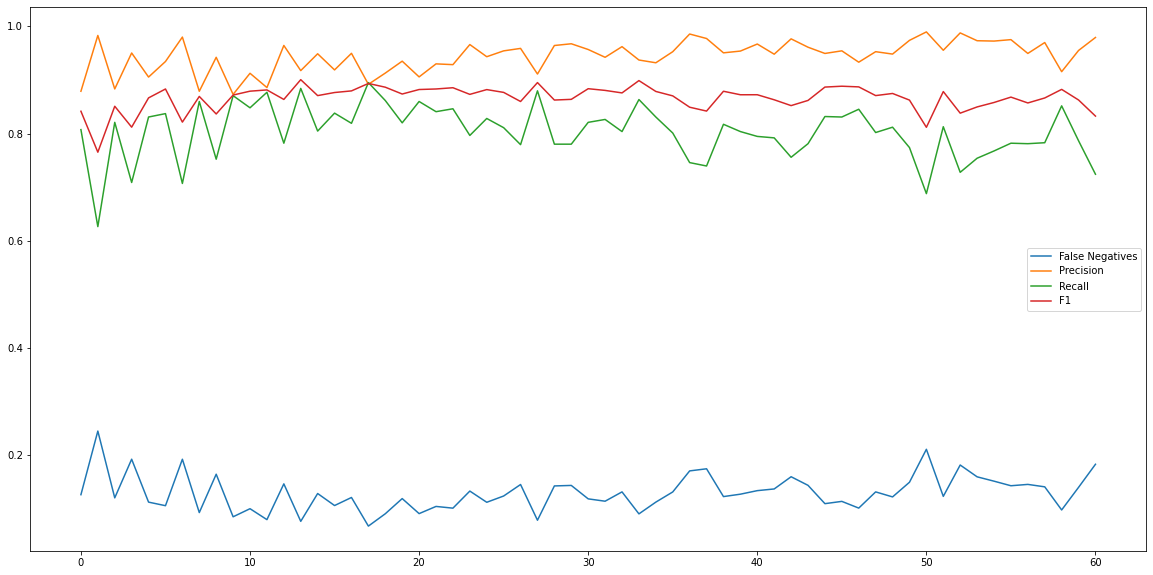

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(FN, label="False Negatives")
ax.plot(Precision, label="Precision")
ax.plot(Recall, label="Recall")
ax.plot(F1, label="F1")
ax.legend()
plt.show()

In [37]:
len(FN[:20])+np.argmin(FN[20:])

27

In [5]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
model.load_weights("save_at_27.h5")

In [6]:
model.summary(line_length=None, positions=None, print_fn=None)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 32) 896         rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 128, 128, 32) 128         conv2d_6[0][0]                   
_______________________________________________________________________________________

## 3. Downloading a Test Dataset

In [38]:
target_database_folder = "D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/"
if not os.path.exists(target_database_folder): os.makedirs(target_database_folder)
    
class1_tags = ["explicit","grotesque","questionable"]
class2_tags = ["safe"]

path_class1 = create_dataset_csv(class1_tags, 1500, target_database_folder)
path_class2 = create_dataset_csv(class2_tags, 1500, target_database_folder)

{'retrieve tag id': "SELECT id FROM new_tags WHERE name IN ('explicit','grotesque','questionable');"}
COPY (SELECT id, image_format, version_path FROM new_images WHERE id IN (SELECT image_id FROM new_image_taggings WHERE tag_id IN ('39068','29300','26707')) ORDER BY RANDOM() LIMIT 1500) TO 'D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/39068_29300_26707.csv' DELIMITER '|' CSV;
{'retrieve tag id': "SELECT id FROM new_tags WHERE name IN ('safe');"}
COPY (SELECT id, image_format, version_path FROM new_images WHERE id IN (SELECT image_id FROM new_image_taggings WHERE tag_id IN ('40482')) ORDER BY RANDOM() LIMIT 1500) TO 'D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/40482.csv' DELIMITER '|' CSV;


In [39]:
path_class1

'D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/39068_29300_26707'

In [40]:
download_images(target_database_folder, path_class1)

#100 sent - #91 image downloaded - #9 errors caught so far.
#200 sent - #175 image downloaded - #25 errors caught so far.
#300 sent - #258 image downloaded - #42 errors caught so far.
#400 sent - #345 image downloaded - #55 errors caught so far.
#500 sent - #427 image downloaded - #73 errors caught so far.
#600 sent - #513 image downloaded - #87 errors caught so far.
#700 sent - #602 image downloaded - #98 errors caught so far.
#800 sent - #693 image downloaded - #107 errors caught so far.
#900 sent - #781 image downloaded - #119 errors caught so far.
#1000 sent - #872 image downloaded - #128 errors caught so far.
#1100 sent - #963 image downloaded - #137 errors caught so far.
#1200 sent - #1051 image downloaded - #149 errors caught so far.
#1300 sent - #1137 image downloaded - #163 errors caught so far.
#1400 sent - #1224 image downloaded - #176 errors caught so far.
#1500 sent - #1310 image downloaded - #190 errors caught so far.
#1500 sent - #1310 image downloaded - #190 errors caug

In [41]:
download_images(target_database_folder, path_class2)

#100 sent - #86 image downloaded - #14 errors caught so far.
#200 sent - #175 image downloaded - #25 errors caught so far.
#300 sent - #265 image downloaded - #35 errors caught so far.
#400 sent - #352 image downloaded - #48 errors caught so far.
#500 sent - #440 image downloaded - #60 errors caught so far.
#600 sent - #531 image downloaded - #69 errors caught so far.
#700 sent - #618 image downloaded - #82 errors caught so far.
#800 sent - #708 image downloaded - #92 errors caught so far.
#900 sent - #799 image downloaded - #101 errors caught so far.
#1000 sent - #880 image downloaded - #120 errors caught so far.
#1100 sent - #972 image downloaded - #128 errors caught so far.
#1200 sent - #1064 image downloaded - #136 errors caught so far.
#1300 sent - #1156 image downloaded - #144 errors caught so far.
#1400 sent - #1243 image downloaded - #157 errors caught so far.
#1500 sent - #1333 image downloaded - #167 errors caught so far.
#1500 sent - #1333 image downloaded - #167 errors caug

In [42]:
def remove_duplicates(folder, class_numbers):
    for file in os.listdir(folder):
        if os.path.exists("D:/repositories/MLpy/data_dump/datasets/ds_test/"+class_numbers+"/"+file):
            os.remove(folder+"/"+file)
            print(f"{class_numbers+'/'+file} removed")

In [45]:
remove_duplicates(path_class1, "39068_29300_26707")

39068_29300_26707/1020156.png removed
39068_29300_26707/1027196.jpg removed
39068_29300_26707/1096889.jpg removed
39068_29300_26707/1097465.jpg removed
39068_29300_26707/1099106.jpg removed
39068_29300_26707/1104629.png removed
39068_29300_26707/1114061.png removed
39068_29300_26707/1114808.png removed
39068_29300_26707/1145256.png removed
39068_29300_26707/1152498.png removed
39068_29300_26707/1166592.png removed
39068_29300_26707/118155.jpg removed
39068_29300_26707/1186053.jpg removed
39068_29300_26707/1195540.PNG removed
39068_29300_26707/1206955.PNG removed
39068_29300_26707/1208727.JPEG removed
39068_29300_26707/1209135.PNG removed
39068_29300_26707/1222112.JPEG removed
39068_29300_26707/1234387.JPEG removed
39068_29300_26707/1235913.PNG removed
39068_29300_26707/1252234.JPEG removed
39068_29300_26707/1306659.PNG removed
39068_29300_26707/1333744.PNG removed
39068_29300_26707/1346450.PNG removed
39068_29300_26707/1348251.PNG removed
39068_29300_26707/1360401.PNG removed
39068_293

In [46]:
remove_duplicates(path_class2, "40482")

40482/1109066.png removed
40482/1124673.jpg removed
40482/1126792.jpeg removed
40482/1160068.jpeg removed
40482/1287131.JPEG removed
40482/1339713.PNG removed
40482/1369269.PNG removed
40482/1418806.JPEG removed
40482/1428616.JPEG removed
40482/1457386.PNG removed
40482/1503222.JPEG removed
40482/1709266.JPEG removed
40482/1736031.PNG removed
40482/1736903.JPEG removed
40482/1778369.PNG removed
40482/1820170.JPEG removed
40482/1824689.PNG removed
40482/2003558.png removed
40482/2005472.jpeg removed
40482/2117120.png removed
40482/2165403.png removed
40482/2189380.jpeg removed
40482/2199149.png removed
40482/2389422.png removed
40482/2389538.png removed
40482/2434461.png removed
40482/2461765.jpg removed
40482/26850.png removed
40482/286675.jpg removed
40482/305468.png removed
40482/44156.png removed
40482/497705.png removed
40482/517920.png removed
40482/548225.png removed
40482/589521.jpeg removed
40482/656432.png removed
40482/705757.png removed
40482/752035.jpg removed
40482/763793.

## 4. Testing the new dataset

In [39]:
def testing_a_new_dataset(path_class0, path_class1):
    Accuracy = []
    FN = []
    Precision = []
    Recall = []
    F1 = []

    idx = 0
    for trained_model in sorted(Path(os.getcwd()).iterdir(), key=os.path.getmtime):
        if trained_model.suffix==".h5":
            true_positive = 0
            true_negative = 0
            false_positive = 0
            false_negative = 0
            model = make_model(input_shape=image_size + (3,), num_classes=2)
            model.compile(optimizer=keras.optimizers.Adam(1e-3),
                          loss="binary_crossentropy",
                          metrics=["accuracy"])
            model.load_weights(trained_model)
            for image in os.listdir(path_class0):
                img = keras.preprocessing.image.load_img(path_class0+image, target_size=image_size)
                img_array = keras.preprocessing.image.img_to_array(img)
                img_array = tf.expand_dims(img_array, 0)
                prediction = model.predict(img_array)
                score = prediction[0]
                if score >= 0.5:false_negative+=1
                else: true_positive+=1
            for image in os.listdir(path_class1):
                img = keras.preprocessing.image.load_img(path_class1+image, target_size=image_size)
                img_array = keras.preprocessing.image.img_to_array(img)
                img_array = tf.expand_dims(img_array, 0)
                prediction = model.predict(img_array)
                score = prediction[0]
                if score >= 0.5: true_negative+=1
                else: false_positive+=1
            total = true_negative+false_positive+false_negative+true_positive
            Accuracy_val = (true_negative+true_positive)/total
            Accuracy.append(Accuracy_val)
            FN_val = false_negative/total
            FN.append(FN_val)
            Precision_val = true_positive/(true_positive+false_positive)
            Precision.append(Precision_val)
            Recall_val = true_positive/(true_positive+false_negative)
            Recall.append(Recall_val)
            F1_val = (2*true_positive)/(2*true_positive+false_positive+false_negative)
            F1.append(F1_val)
            print(f"Model's performance after {idx+1} epoch(s): Accuracy: {round(Accuracy_val,4)}, "+
                  f"False Negative: {round(FN_val,4)}, " + 
                  f"Precision: {round(Precision_val,4)}, " + 
                  f"Recall: {round(Recall_val,4)}, " + 
                  f"F1: {round(F1_val,4)}")
            idx+=1
    return Accuracy, FN, Precision, Recall, F1

In [40]:
Acc, FN, Pre, Rec, F1 = testing_a_new_dataset("D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/39068_29300_26707/",
                     "D:/repositories/MLpy/data_dump/datasets/ds_test/test_data/40482/")

Model's performance after 1 epoch(s): Accuracy: 0.6738, False Negative: 0.2059, Precision: 0.6886, Recall: 0.5637, F1: 0.6199
Model's performance after 2 epoch(s): Accuracy: 0.6189, False Negative: 0.3668, Precision: 0.8801, Recall: 0.2229, F1: 0.3557
Model's performance after 3 epoch(s): Accuracy: 0.7298, False Negative: 0.1523, Precision: 0.7306, Recall: 0.6774, F1: 0.703
Model's performance after 4 epoch(s): Accuracy: 0.6922, False Negative: 0.2738, Precision: 0.8536, Recall: 0.4198, F1: 0.5628
Model's performance after 5 epoch(s): Accuracy: 0.738, False Negative: 0.1519, Precision: 0.7441, Recall: 0.6782, F1: 0.7096
Model's performance after 6 epoch(s): Accuracy: 0.7483, False Negative: 0.1703, Precision: 0.7874, Recall: 0.6392, F1: 0.7056
Model's performance after 7 epoch(s): Accuracy: 0.6815, False Negative: 0.3045, Precision: 0.9233, Recall: 0.3547, F1: 0.5125
Model's performance after 8 epoch(s): Accuracy: 0.7274, False Negative: 0.1277, Precision: 0.7038, Recall: 0.7294, F1: 0

In [45]:
df = pd.DataFrame({'Accuracy':Acc, 'False Negative':FN, 'Precision':Pre, 'Recall':Rec, 'F1':F1})
csv_data = df.to_csv('test_results_2020_11_11.csv', index = True) 
print('\nCSV String:\n', csv_data) 


CSV String:
 None
